<a href="https://www.kaggle.com/code/rajgolakiya/new-eye-disease?scriptVersionId=191617277" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

`os:` For interacting with the operating system, such as file and directory operations.

`numpy:` Provides support for numerical computations and array manipulations.

`PIL:` Handles image processing tasks like opening and converting images.

`torch:` Core library for creating and training deep learning models with PyTorch.

`shutil:` Facilitates high-level file operations like copying and moving files.

`random:` Used for generating random numbers, helpful for data shuffling and splitting.

`torchvision:` Includes pre-built models, datasets, and image transformations for computer vision.

`matplotlib.pyplot:` Used for creating static, animated, and interactive plots.

`pandas:` Provides data structures and functions for data manipulation and analysis.

`timm:` Provides additional pre-trained models and efficient architectures.

`sklearn.metrics:` Contains tools for evaluating model performance, such as confusion matrix and classification report.

`seaborn:` Extends Matplotlib for more sophisticated data visualizations, like heatmaps.


In [45]:
import os
import numpy as np
import pandas as pd
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
df = pd.read_csv('/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv')

In [8]:
df.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg


In [10]:
pd.set_option('display.max_rows', None)


In [16]:
# df['Right-Diagnostic Keywords'].value_counts()

# Pre-processing 

# The images right now are not in a proper labeled format, for futher classification process, the images needs be classified into right labels, the below given code is used fo classification of the images into 3 different categories of images, the images are classified into 3 categories right now is because the eye images are much similar to each other so it will create biased results when classifying the images into different categories, so, that is the reason the images are classified into only 3 categories for now.

In [17]:
# Define the custom function for exact matching
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'
    elif keyword == 'retinopathy':
        return 'Diabetes'
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'cataract':
        return 'Cataract'
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'
#     elif keyword == 'pathological myopia':
#         return 'Pathological Myopia'
#     elif keyword == 'dry age-related macular degeneration':
#         return 'Age-related Macular Degeneration'
    elif keyword == 'glaucoma':
        return 'Glaucoma'
    elif keyword == 'drusen':
        return 'Drusen'
#     elif keyword == 'hypertensive retinopathy':
#         return 'Hypertension'
    else:
        return 'Other diseases/abnormalities'

# Applying the custom function to the 'Right-Diagnostic Keywords' and 'Left-Diagnostic Keywords' columns
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact)
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)

# Create separate DataFrames for right and left eye
df_right = df[['Right-Diagnostic Keywords', 'right_label_column']]
df_left = df[['Left-Diagnostic Keywords', 'left_label_column']]


In [18]:
df_right = pd.concat([df_right, df[['Right-Fundus']]], axis=1)
df_right.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_file"}, inplace=True)
df_right.drop("Right-Diagnostic Keywords", axis=1, inplace=True)
df_left = pd.concat([df_left, df[['Left-Fundus']]], axis=1)
df_left.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_file"}, inplace=True)
df_labeled = pd.concat([df_right, df_left])
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)
df_labeled['disease'].value_counts()


disease
Normal Fundus                   5501
Other diseases/abnormalities    4350
Diabetes                        1748
Cataract                         518
Glaucoma                         397
Drusen                           270
Name: count, dtype: int64

# There are two types of images in the dataset, the Right eye image and, the Left eye image, the labele attatched to a particular eye image is matched with the diseease keyword if both the keywords are a match then the particular eye image will be given a label of that disease in a new column.


In [19]:
df_labeled.head()

,disease,image_file
0,Normal Fundus,0_right.jpg
1,Normal Fundus,1_right.jpg
2,Diabetes,2_right.jpg
3,Other diseases/abnormalities,4_right.jpg
4,Diabetes,5_right.jpg


# As we are proceeding with 3 categories of eye disease classification, the fourthc class `other diseases` which contains all the non classified eye disease images, removing the fourth class to avoid any distraction for the model to understand the patterns among 3 categories of the disease.

In [20]:
df_labeled = df_labeled.loc[(df_labeled['disease'] == 'Normal Fundus') | (df_labeled['disease'] == 'Cataract') | (df_labeled['disease'] == 'Diabetes')]

# The images are classified into categories, now the task is to store the labeled images into their respected disease folder, the `classified_images` folder, which will contain folders of disease containing eye images of the particular disease.

In [21]:
# Create main directory and subdirectories if they don't exist
base_dir = 'classified_images/train'
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories for each label
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Define the source directory
source_dir = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/'

# Copy images to corresponding folders
for index, row in df_labeled.iterrows():
    source_file = os.path.join(source_dir, row['image_file'])  # Path to the image in the source directory
    label = row['disease']
    dest_folder = os.path.join(base_dir, label)
    dest_file = os.path.join(dest_folder, row['image_file'])

    if not os.path.isfile(source_file):
        print(f"File {source_file} does not exist.")
        continue

    # Copy the file
    shutil.copy2(source_file, dest_file)
#     print(f"Copied {source_file} to {dest_file}")

# Becuase we have created a new folder for the images classified, we only have the train set for the images, creating a test set for model training is essential.

In [23]:
# Set the directories
train_dir = './classified_images/train'
test_dir = './classified_images/test'

# Create the test directory if it doesn't exist
os.makedirs(test_dir, exist_ok=True)

# Define the test set size (e.g., 20% of the images)
test_size = 0.2

# Iterate over each label folder in the train directory
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)
    label_test_dir = os.path.join(test_dir, label_folder)
    
    # Create the corresponding label folder in the test directory
    os.makedirs(label_test_dir, exist_ok=True)
    
    # List all images in the current label folder
    images = os.listdir(label_train_dir)
    
    # Shuffle the images
    random.shuffle(images)
    
    # Determine the number of images for the test set
    num_test_images = int(len(images) * test_size)
    
    # Split the images into training and test sets
    test_images = images[:num_test_images]
    
    # Move the test images to the test directory
    for image in test_images:
        src_path = os.path.join(label_train_dir, image)
        dst_path = os.path.join(label_test_dir, image)
        shutil.move(src_path, dst_path)

print("Test set created successfully.")


Test set created successfully.


In [24]:
# Loading the directories
train_dir = '/kaggle/working/classified_images/train'
test_dir = '/kaggle/working/classified_images/test'

# Normalization scales pixel values to a consistent range, improving model training stability and performance. This is achieved by adjusting pixel values based on the mean and standard deviation of the dataset.

In [25]:
def calculate_mean_std(directory):
    image_files = [os.path.join(root, file)
                   for root, _, files in os.walk(directory)
                   for file in files
                   if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Initialize lists to store pixel values
    pixel_values = []

    for image_file in image_files:
        image = Image.open(image_file)
        image_np = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
        pixel_values.append(image_np)

    # Stack all pixel values and calculate mean and std
    all_pixels = np.concatenate([img.reshape(-1, 3) for img in pixel_values], axis=0)
    
    mean = np.mean(all_pixels, axis=0)
    std = np.std(all_pixels, axis=0)
    
    return mean, std

# Calculate mean and std for train directory
train_mean, train_std = calculate_mean_std(train_dir)

print(f"Train Mean: {train_mean}")
print(f"Train Std: {train_std}")

In [26]:
# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# datasets.ImageFolder creates a dataset from image files organized in subdirectories, where each subdirectory name is treated as a class label. The transform parameter applies preprocessing (e.g., resizing, normalization) to each image in the dataset.

In [27]:
# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [28]:
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Displaying the preprocessed images to check the outcome of the image preprocessing 

In [31]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([2, 2, 2, 2, 2, 2])


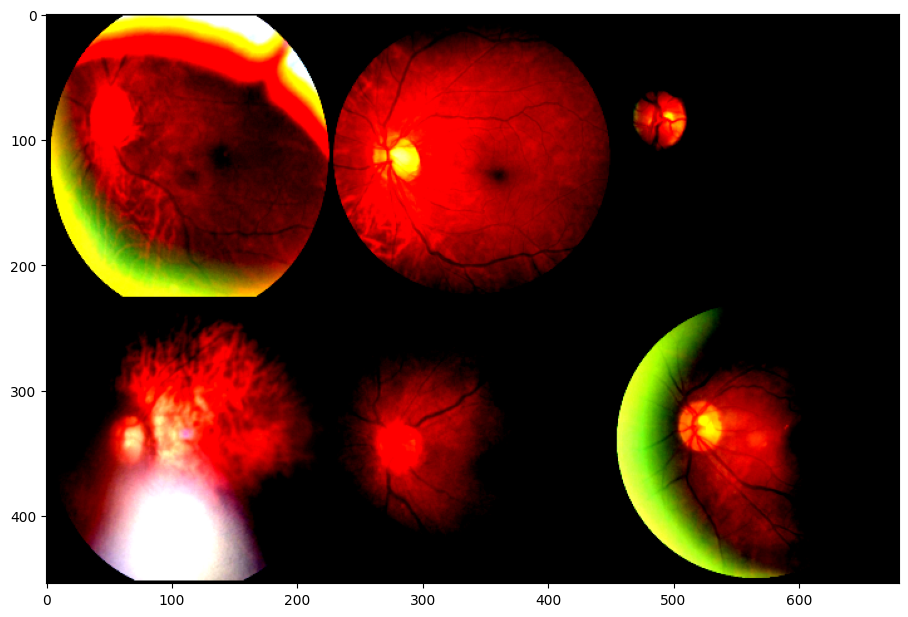

In [32]:
show_transformed_images(train_dataset)

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Resnet50
### ResNet (Residual Network) is a deep convolutional neural network architecture known for its ability to train very deep networks by using residual connections or skip connections, which help mitigate the vanishing gradient problem. This architecture allows the model to learn residual mappings rather than direct mappings, improving accuracy and enabling effective training of deeper networks.

### The ResNet-50 model’s final fully connected layer (fc) is adjusted to match the number of classes in your dataset. By default, ResNet-50 outputs predictions for 1,000 ImageNet classes. This modification ensures the model can output predictions for the specific number of classes in your dataset.

In [35]:
# Initialize the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s] 


# Efficient-net

### EfficientNet is a convolutional neural network architecture designed for efficiency and accuracy. It uses a compound scaling method that uniformly scales depth, width, and resolution to achieve better performance with fewer parameters compared to other models. This makes EfficientNet both computationally efficient and effective for image classification tasks.

### EfficientNet-B0 has a classifier layer for predicting ImageNet classes. This code replaces the classifier’s final linear layer to match the number of classes in your dataset, ensuring the model can output predictions for your specific class labels.


In [40]:
# Initialize the pretrained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)


# Vision Transformer (ViT)

### Vision Transformer (ViT) is a model that applies transformer architecture, traditionally used in NLP, to image classification. It excels in capturing global context and dependencies in images, making it effective for tasks with large-scale datasets and complex visual patterns.


### This code replaces the final linear layer of the Vision Transformer to match the number of classes in your specific dataset, ensuring the model can classify images into your defined categories.


In [46]:
# Initialize the pretrained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# To run the process quickly, usng GPU if available for the environment to run, otherwise CPU.

In [47]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### `criterion = nn.CrossEntropyLoss()` : This is a loss function used for classification tasks. It computes the difference between the predicted class probabilities and the true class labels. It is appropriate for multi-class classification problems where the goal is to minimize the prediction error across multiple classes.

### `optimizer = optim.Adam(model.parameters(), lr=0.001)` : This is an optimization algorithm that adjusts the weights of the model based on the gradients computed during training. Adam (Adaptive Moment Estimation) is widely used due to its efficiency and effectiveness in handling sparse gradients and noisy data.

### `scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)` : This adjusts the learning rate during training by reducing it periodically. A learning rate scheduler helps improve convergence and avoid overshooting by reducing the learning rate at specified intervals, which helps the model fine-tune its weights more precisely in later epochs.

# Function for trying and saving differnt model along with generating the confusion matrix

#### Steps

Starts with a pretrained model and adjust it to fit the number of classes in your dataset.

Define how to measure errors, update model parameters, and adjust the learning rate during training.

Train the model, check its performance on test data, save the best version, and review results with metrics like accuracy and confusion matrix.


In [52]:
def train_and_evaluate(model, train_loader, test_loader, num_classes, num_epochs=10, model_name='model'):
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_accuracy = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% ({correct}/{total})')
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}% ({val_correct}/{val_total})')

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), f'{model_name}_best.pth')

        # Update learning rate
        scheduler.step()

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best model saved with validation accuracy: {best_accuracy:.2f}%')

    # Generate confusion matrix and classification report
    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, train_loader.dataset.classes)

    report = classification_report(all_labels, all_preds, target_names=train_loader.dataset.classes)
    print("\nClassification Report:\n", report)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.ImageFolder(root='path_to_train_data', transform=transform)
test_dataset = datasets.ImageFolder(root='path_to_test_data', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [57]:
num_classes = 3  # Adjust based on your dataset

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6727, Accuracy: 71.02% (2255/3175)
Validation Loss: 0.5733, Validation Accuracy: 75.88% (601/792)
Epoch [2/10], Loss: 0.5646, Accuracy: 76.35% (2424/3175)
Validation Loss: 0.7539, Validation Accuracy: 73.36% (581/792)
Epoch [3/10], Loss: 0.5012, Accuracy: 79.81% (2534/3175)
Validation Loss: 0.5498, Validation Accuracy: 77.02% (610/792)
Epoch [4/10], Loss: 0.4844, Accuracy: 80.44% (2554/3175)
Validation Loss: 0.4617, Validation Accuracy: 82.45% (653/792)
Epoch [5/10], Loss: 0.4457, Accuracy: 82.90% (2632/3175)
Validation Loss: 0.4726, Validation Accuracy: 81.57% (646/792)
Epoch [6/10], Loss: 0.4468, Accuracy: 82.11% (2607/3175)
Validation Loss: 0.4169, Validation Accuracy: 82.58% (654/792)
Epoch [7/10], Loss: 0.4149, Accuracy: 84.03% (2668/3175)
Validation Loss: 0.5159, Validation Accuracy: 81.82% (648/792)
Epoch [8/10], Loss: 0.3415, Accuracy: 87.28% (2771/3175)
Validation Loss: 0.3952, Validation Accuracy: 85.73% (679/792)
Epoch [9/10], Loss: 0.2800, Accuracy: 89

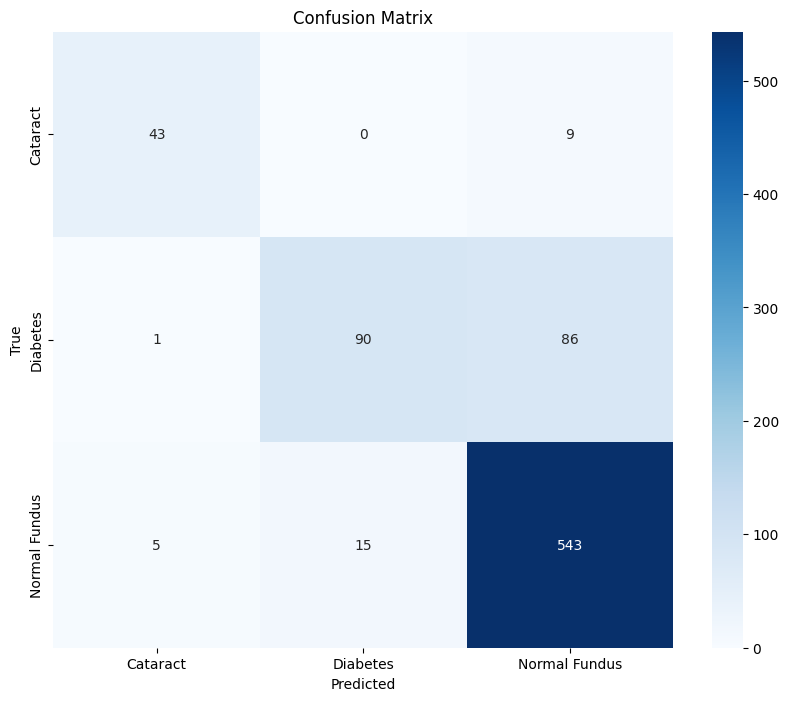

In [58]:
# Train and evaluate ResNet-50
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)
train_and_evaluate(resnet50_model, train_loader, test_loader, num_classes, num_epochs=10, model_name='resnet50')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.5343, Accuracy: 78.20% (2483/3175)
Validation Loss: 0.4583, Validation Accuracy: 85.10% (674/792)
Epoch [2/10], Loss: 0.3802, Accuracy: 86.14% (2735/3175)
Validation Loss: 0.3803, Validation Accuracy: 86.87% (688/792)
Epoch [3/10], Loss: 0.3154, Accuracy: 88.06% (2796/3175)
Validation Loss: 0.3611, Validation Accuracy: 86.62% (686/792)
Epoch [4/10], Loss: 0.2223, Accuracy: 91.02% (2890/3175)
Validation Loss: 0.5514, Validation Accuracy: 82.07% (650/792)
Epoch [5/10], Loss: 0.1793, Accuracy: 93.20% (2959/3175)
Validation Loss: 0.5035, Validation Accuracy: 86.36% (684/792)
Epoch [6/10], Loss: 0.1483, Accuracy: 94.87% (3012/3175)
Validation Loss: 0.5064, Validation Accuracy: 82.58% (654/792)
Epoch [7/10], Loss: 0.1337, Accuracy: 95.28% (3025/3175)
Validation Loss: 0.6031, Validation Accuracy: 86.62% (686/792)
Epoch [8/10], Loss: 0.0662, Accuracy: 97.73% (3103/3175)
Validation Loss: 0.4605, Validation Accuracy: 87.63% (694/792)
Epoch [9/10], Loss: 0.0378, Accuracy: 98

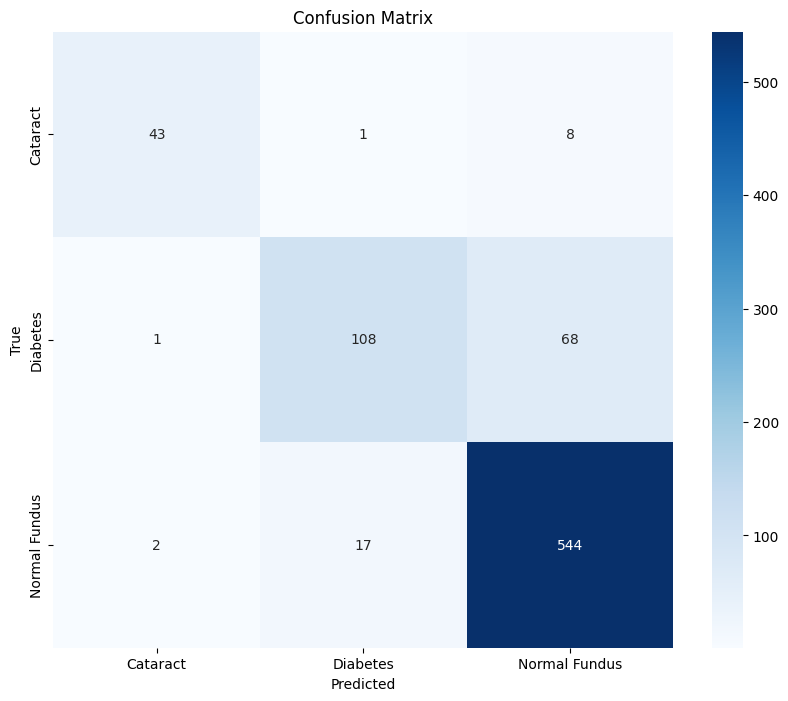

In [59]:
# Train and evaluate EfficientNet
efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)
train_and_evaluate(efficientnet_model, train_loader, test_loader, num_classes, num_epochs=10, model_name='efficientnet_b0')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6060, Accuracy: 74.24% (2357/3175)
Validation Loss: 0.5966, Validation Accuracy: 76.14% (603/792)
Epoch [2/10], Loss: 0.4828, Accuracy: 80.50% (2556/3175)
Validation Loss: 0.4522, Validation Accuracy: 82.07% (650/792)
Epoch [3/10], Loss: 0.4501, Accuracy: 81.98% (2603/3175)
Validation Loss: 0.4553, Validation Accuracy: 79.17% (627/792)
Epoch [4/10], Loss: 0.4141, Accuracy: 84.13% (2671/3175)
Validation Loss: 0.4211, Validation Accuracy: 83.33% (660/792)
Epoch [5/10], Loss: 0.3742, Accuracy: 85.29% (2708/3175)
Validation Loss: 0.4315, Validation Accuracy: 83.84% (664/792)
Epoch [6/10], Loss: 0.3688, Accuracy: 86.36% (2742/3175)
Validation Loss: 0.4077, Validation Accuracy: 83.59% (662/792)
Epoch [7/10], Loss: 0.3189, Accuracy: 87.31% (2772/3175)
Validation Loss: 0.4583, Validation Accuracy: 84.72% (671/792)
Epoch [8/10], Loss: 0.2369, Accuracy: 91.21% (2896/3175)
Validation Loss: 0.3430, Validation Accuracy: 87.88% (696/792)
Epoch [9/10], Loss: 0.1644, Accuracy: 94

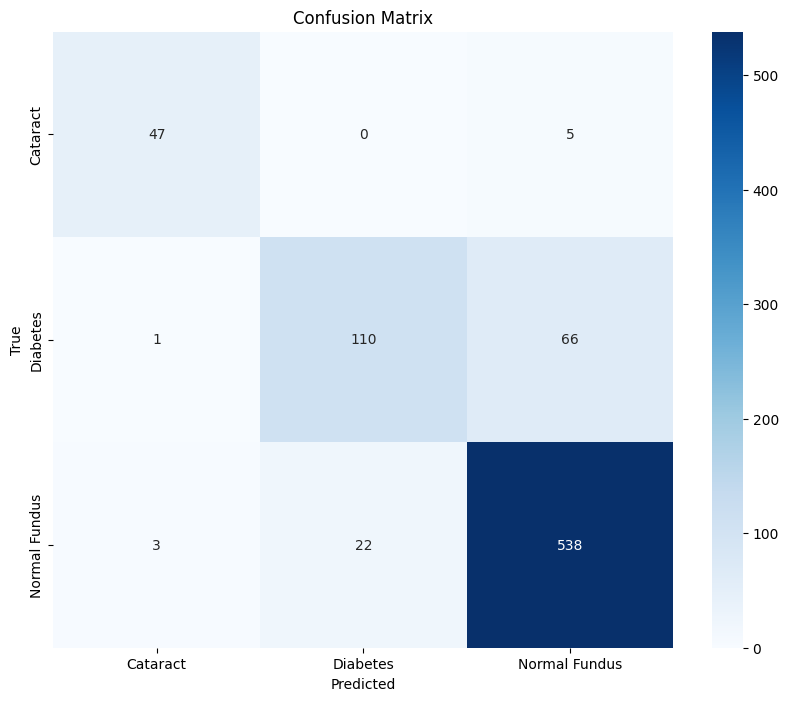

In [60]:
# Train and evaluate DenseNet
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)
train_and_evaluate(densenet_model, train_loader, test_loader, num_classes, num_epochs=10, model_name='densenet121')

Epoch [1/10], Loss: 1.0658, Accuracy: 68.50% (2175/3175)
Validation Loss: 0.7940, Validation Accuracy: 71.09% (563/792)
Epoch [2/10], Loss: 0.7837, Accuracy: 69.64% (2211/3175)
Validation Loss: 0.7396, Validation Accuracy: 71.46% (566/792)
Epoch [3/10], Loss: 0.7472, Accuracy: 70.33% (2233/3175)
Validation Loss: 0.7029, Validation Accuracy: 71.84% (569/792)
Epoch [4/10], Loss: 0.7351, Accuracy: 71.34% (2265/3175)
Validation Loss: 0.7116, Validation Accuracy: 71.46% (566/792)
Epoch [5/10], Loss: 0.7206, Accuracy: 71.18% (2260/3175)
Validation Loss: 0.6990, Validation Accuracy: 72.22% (572/792)
Epoch [6/10], Loss: 0.7154, Accuracy: 71.43% (2268/3175)
Validation Loss: 0.6993, Validation Accuracy: 71.97% (570/792)
Epoch [7/10], Loss: 0.6978, Accuracy: 71.40% (2267/3175)
Validation Loss: 0.7448, Validation Accuracy: 71.09% (563/792)
Epoch [8/10], Loss: 0.6796, Accuracy: 71.81% (2280/3175)
Validation Loss: 0.6943, Validation Accuracy: 71.72% (568/792)
Epoch [9/10], Loss: 0.6582, Accuracy: 72

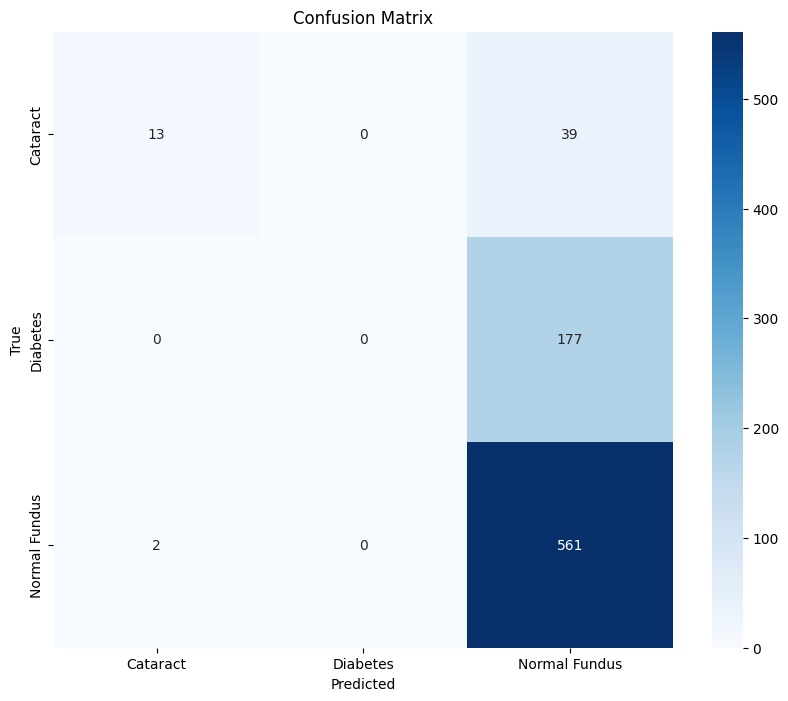

In [61]:
# Train and evaluate Vision Transformer (ViT)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Linear(vit_model.head.in_features, num_classes)
train_and_evaluate(vit_model, train_loader, test_loader, num_classes, num_epochs=10, model_name='vit_base_patch16_224')